In [143]:
import cantera as ct
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from IPython.display import display

PSI2PA = 6894.76


OF = 1

# Propellant Temperatures [K]
T_amb = 298
T_ox = 298
T_fuel = 298
T_mix = T_ox *(OF/(OF+1)) + T_fuel *(OF/(OF+1))

# Propellant Pressures [Pa]
P_wsr = 500 * PSI2PA
P_amb = ct.one_atm

# Mass Flow Rates [kg/s]
mdot_total = 0.12
mdot_ox = mdot_total*(OF/(OF+1))
mdot_fuel = mdot_total*(1/(OF+1))


## Define Reactor Network ##

# Jet-A reaction mechanism
mech = "A2NTC_skeletal.yaml"

# Gas Compositions #

# Pre-Mixed Inlet
Y_mix = {"POSF10325": (1/(OF+1)), "O2": (OF/(OF+1))}
sol_inlet = ct.Solution(mech)
sol_inlet.TPY = T_mix, P_wsr, Y_mix

# Arbitrary Exhaust 
sol_exhaust = ct.Solution(mech)
#sol_exhaust.TP = T_amb, P_amb

# Reservoirs
res_inlet = ct.Reservoir(sol_inlet, clone=True)
res_exhaust = ct.Reservoir(sol_exhaust, clone=True)

# Well Stirred Reactor
rctr_wsr = ct.ConstPressureReactor(sol_inlet, energy='on')

# Mass Flow Controllers
mfc_inlet = ct.MassFlowController(upstream=res_inlet, downstream=rctr_wsr, mdot=mdot_total)
mfc_outlet = ct.MassFlowController(upstream=rctr_wsr, downstream=res_exhaust, mdot=mdot_total)
#pc_outlet = ct.PressureController(upstream=rctr_wsr, downstream=res_exhaust, primary=mfc_inlet, K=1e-3)

sim = ct.ReactorNet([rctr_wsr])

C:\Users\Louis\AppData\Local\Temp\ipykernel_35568\1435041509.py:50: DeprecationWarning: ReactorBase.__init__: After Cantera 3.2, the default value of the `clone` argument will be `True`, resulting in an independent copy of the `phase` being created for use by this reactor. Add the `clone=False` argument to retain the old behavior of sharing `Solution` objects.
  rctr_wsr = ct.ConstPressureReactor(sol_inlet, energy='on')


In [144]:
# Create a SolutionArray to store the data
time_history = ct.SolutionArray(rctr_wsr.thermo, extra=["t"])
max_sim_time = 500
# Start the stopwatch
tic = time.time()

# Set simulation start time to zero
t = 0
counter = 1
while t < max_sim_time:
    t = sim.step()

    # We will store only every 10th value. Remember, we have 1200+ species, so there
    # will be 1200+ columns for us to work with
    if counter % 10 == 0:
        # Extract the state of the reactor
        time_history.append(rctr_wsr.thermo.state, t=t)

    counter += 1

# Stop the stopwatch
toc = time.time()
print(f"Simulation Took {toc-tic:3.2f}s to compute, with {counter} steps")

Simulation Took 0.00s to compute, with 7 steps


C:\Users\Louis\AppData\Local\Temp\ipykernel_35568\4139110179.py:2: DeprecationWarning: ReactorBase.thermo: To be removed after Cantera 3.2. Renamed to `phase`.
  time_history = ct.SolutionArray(rctr_wsr.thermo, extra=["t"])


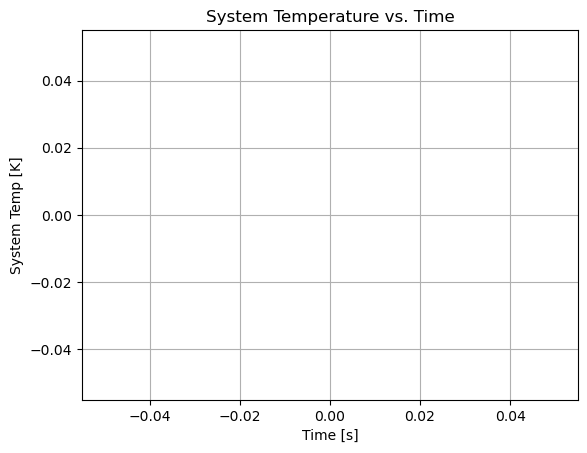

In [145]:
plt.figure()
plt.plot(time_history.t, time_history.T, '-o')
plt.xlabel('Time [s]')
plt.ylabel('System Temp [K]')
plt.title("System Temperature vs. Time")
plt.grid(True)
plt.show()

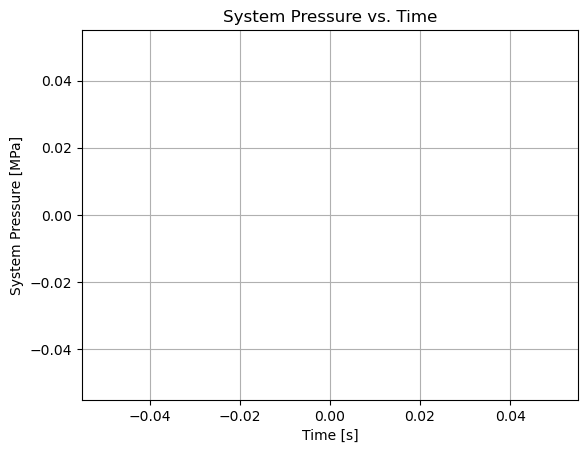

In [146]:
plt.figure()
plt.plot(time_history.t, time_history.P * 1e-6, '-o')
plt.xlabel('Time [s]')
plt.ylabel('System Pressure [MPa]')
plt.title("System Pressure vs. Time")
plt.grid(True)
plt.show()

In [147]:
rctr_wsr

In [148]:
time_history.P

array([], dtype=float64)

In [149]:
df = time_history.to_pandas()
sim.solve_steady()

In [150]:
gas = rctr_wsr.phase
print(gas.T, gas.P / PSI2PA, gas.h)

298.0000000000036 499.99999999999994 -906872.9965402201


In [ ]:
s